# Phase 4: Data Preprocessing & Feature Engineering

This notebook focuses on preparing the weather sensor data for model development by cleaning the dataset, engineering relevant features, creating target labels, scaling the data, and splitting it into training, validation, and testing sets.

## Objectives:
1. Clean the raw environmental sensor data
2. Create derived weather features to enhance model performance
3. Generate categorical weather condition labels
4. Normalize data for ESP32-S3 compatibility
5. Create stratified data splits for model training

## Dataset Summary:
- **Records**: 693,220 environmental measurements
- **Parameters**: Temperature, Humidity, Pressure, Illuminance
- **Hardware**: ESP32-S3 with BME280, AHT10, and BH1750 sensors

---

## Section 1: Import Required Libraries

In [1]:
# Import required libraries
import os
import sys
import pandas as pd
import numpy as np
import json
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Data preprocessing and machine learning
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy import stats
from scipy.stats import normaltest, skew, kurtosis
import joblib

# Configure display settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

print(f"📊 Data Preprocessing Notebook initialized at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"✓ All preprocessing libraries imported successfully")

📊 Data Preprocessing Notebook initialized at: 2025-09-15 21:13:13
✓ All preprocessing libraries imported successfully


## Section 2: Load & Explore Raw Dataset

In [2]:
# Set project paths
PROJECT_ROOT = Path(r"G:\\CSE Weather Model")
DATA_DIR = PROJECT_ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"

# Create processed directory if it doesn't exist
PROCESSED_DIR.mkdir(exist_ok=True)

print("📥 Loading Primary Environmental Dataset...")
print("=" * 50)

# Load primary dataset with optimized parameters
primary_data_path = RAW_DATA_DIR / "primary_environmental" / "DATA-large.CSV"

# Check file size first
file_size_mb = primary_data_path.stat().st_size / (1024**2)
print(f"📁 File size: {file_size_mb:.1f} MB")

# Load with optimized data types for faster processing
print(f"🔧 Loading with optimized data types...")
dtype_map = {
    'temperature': 'float32',  # Reduce precision for speed
    'humidity': 'float32',
    'pressure': 'float32',
    'lux': 'float32'
}

# Load dataset efficiently
start_time = datetime.now()
df = pd.read_csv(primary_data_path, dtype=dtype_map, low_memory=False)
load_time = (datetime.now() - start_time).total_seconds()

# Fast basic info
print(f"✅ Primary dataset loaded in {load_time:.2f}s:")
print(f"   📊 Shape: {df.shape}")
print(f"   📋 Columns: {list(df.columns)}")
print(f"   📈 Total records: {len(df):,}")

# Display sample
print(f"\n🔍 Dataset Sample (first 5 rows):")
print(df.head())

# Check for timestamp column
has_timestamp = any(col.lower() in ['timestamp', 'time', 'date', 'datetime'] for col in df.columns)
print(f"\n⏰ Timestamp column detected: {'Yes' if has_timestamp else 'No'}")

# Quick data summary
print(f"\n📊 Quick Data Summary:")
print(df.describe().round(2))

📥 Loading Primary Environmental Dataset...
📁 File size: 30.1 MB
🔧 Loading with optimized data types...
✅ Primary dataset loaded in 1.27s:
   📊 Shape: (693220, 5)
   📋 Columns: ['time', 'temperature', 'humidity', 'pressure', 'lux']
   📈 Total records: 693,220

🔍 Dataset Sample (first 5 rows):
                 time  temperature  humidity  pressure    lux
0   2022/3/12 22:32:2       24.200    32.700 98490.453 10.000
1   2022/3/12 22:32:6       24.000    33.900 98486.977 12.080
2  2022/3/12 22:32:11       24.100    33.900 98488.273 22.920
3  2022/3/12 22:32:16       24.100    33.800 98489.578 22.920
4  2022/3/12 22:32:21       24.100    35.000 98489.492 22.920

⏰ Timestamp column detected: Yes

📊 Quick Data Summary:
       temperature   humidity   pressure        lux
count   693220.000 693220.000 693220.000 693220.000
mean        22.200     39.230  98639.590     28.360
std          1.040      4.070    984.710     55.280
min         19.000     29.300  96352.680      0.000
25%         21.600

## Section 3: Data Cleaning

This section focuses on handling missing values, removing duplicates, converting pressure units, and filtering outliers.

In [3]:
print("🧹 DATA CLEANING PROCESS")
print("=" * 50)

# Store original row count
original_count = len(df)
print(f"Original dataset: {original_count:,} records")

# 1. Check for missing values
print("\n📊 Missing Value Analysis:")
missing_counts = df.isnull().sum()
missing_percentage = (missing_counts / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_counts,
    'Percentage': missing_percentage
})
print(missing_df)

# Handle missing values if any exist
if missing_counts.sum() > 0:
    print("\n🔧 Handling missing values...")
    
    # For numerical columns, fill with median (more robust than mean)
    for col in ['temperature', 'humidity', 'pressure', 'lux']:
        if missing_counts[col] > 0:
            df[col] = df[col].fillna(df[col].median())
            print(f"   • Filled {missing_counts[col]:,} missing values in {col} with median")
    
    # Verify all missing values are handled
    remaining_missing = df.isnull().sum().sum()
    print(f"   • Remaining missing values: {remaining_missing:,}")
else:
    print("✓ No missing values detected")

# 2. Pressure unit conversion (Pa to hPa)
print("\n🔧 Applying pressure unit conversion (Pa → hPa)...")

def convert_pressure_units(df, column='pressure', from_unit='Pa', to_unit='hPa'):
    """Convert pressure between different units.
    
    Supports: Pa, hPa, mbar, bar, atm, mmHg, inHg
    
    Args:
        df: DataFrame containing pressure data
        column: Name of pressure column
        from_unit: Original pressure unit
        to_unit: Target pressure unit
    
    Returns:
        DataFrame with converted pressure values
    """
    # Define conversion factors to Pa
    to_pascal = {
        'Pa': 1.0,
        'hPa': 100.0,
        'mbar': 100.0,  # 1 mbar = 100 Pa
        'bar': 100000.0,  # 1 bar = 100,000 Pa
        'atm': 101325.0,  # 1 atm = 101,325 Pa
        'mmHg': 133.322,  # 1 mmHg = 133.322 Pa
        'inHg': 3386.39  # 1 inHg = 3,386.39 Pa
    }
    
    # Make a copy of the dataframe to avoid modifying the original
    df_converted = df.copy()
    
    # Convert from source unit to Pascal first
    if from_unit not in to_pascal:
        raise ValueError(f"Unsupported source unit: {from_unit}")
    
    if to_unit not in to_pascal:
        raise ValueError(f"Unsupported target unit: {to_unit}")
    
    # Convert: source → Pa → target
    df_converted[column] = df_converted[column] * to_pascal[from_unit] / to_pascal[to_unit]
    
    return df_converted

# Check if pressure conversion is needed
mean_pressure = df['pressure'].mean()
if mean_pressure > 50000:  # Likely in Pa if value is very large
    df = convert_pressure_units(df, column='pressure', from_unit='Pa', to_unit='hPa')
    print(f"✓ Pressure values converted from Pa to hPa")
else:
    print(f"✓ Pressure values already in appropriate range (mean: {mean_pressure:.2f}), no conversion needed")

# 3. Remove duplicate rows
print("\n🔍 Checking for duplicate records...")
duplicates = df.duplicated().sum()
duplicate_percentage = (duplicates / len(df)) * 100
print(f"   • Found {duplicates:,} duplicate rows ({duplicate_percentage:.2f}%)")

if duplicates > 0:
    df = df.drop_duplicates()
    print(f"✓ Removed {duplicates:,} duplicate rows, {len(df):,} rows remaining")
else:
    print(f"✓ No duplicate rows found")

# 4. Remove outliers outside of sensor ranges
print("\n🔍 Filtering outliers outside sensor ranges...")

# Define expected ranges for each parameter
sensor_ranges = {
    'temperature': (-50, 60),  # °C, reasonable global range
    'humidity': (0, 100),      # %, theoretical range
    'pressure': (870, 1085),   # hPa, extremes on Earth
    'lux': (0, 130000)         # lux, from darkness to direct sunlight
}

# Count and remove values outside expected ranges
outliers_removed = 0
for col, (min_val, max_val) in sensor_ranges.items():
    # Count outliers
    outliers = ((df[col] < min_val) | (df[col] > max_val)).sum()
    if outliers > 0:
        outlier_percentage = (outliers / len(df)) * 100
        print(f"   • {col.capitalize()}: {outliers:,} values ({outlier_percentage:.2f}%) outside range [{min_val}, {max_val}]")
        
        # Remove outliers
        df = df[(df[col] >= min_val) & (df[col] <= max_val)]
        outliers_removed += outliers
    else:
        print(f"   • {col.capitalize()}: No values outside range [{min_val}, {max_val}]")

print(f"✓ Total outliers removed: {outliers_removed:,}")

# Report final dataset size after cleaning
final_count = len(df)
removed_percentage = ((original_count - final_count) / original_count) * 100
print(f"\n📊 Clean dataset: {final_count:,} records ({removed_percentage:.2f}% removed during cleaning)")

# Basic statistics after cleaning
print("\n📊 Clean Dataset Statistics:")
print(df.describe().round(2))

print("\n✅ Data cleaning completed successfully!")

🧹 DATA CLEANING PROCESS
Original dataset: 693,220 records

📊 Missing Value Analysis:
             Missing Values  Percentage
time                      0       0.000
temperature               0       0.000
humidity                  0       0.000
pressure                  0       0.000
lux                       0       0.000
✓ No missing values detected

🔧 Applying pressure unit conversion (Pa → hPa)...
✓ Pressure values converted from Pa to hPa

🔍 Checking for duplicate records...
   • Found 0 duplicate rows (0.00%)
✓ No duplicate rows found

🔍 Filtering outliers outside sensor ranges...
   • Temperature: No values outside range [-50, 60]
   • Humidity: No values outside range [0, 100]
   • Pressure: No values outside range [870, 1085]
   • Lux: No values outside range [0, 130000]
✓ Total outliers removed: 0

📊 Clean dataset: 693,220 records (0.00% removed during cleaning)

📊 Clean Dataset Statistics:
       temperature   humidity   pressure        lux
count   693220.000 693220.000 6932

## Section 4: Feature Engineering

This section creates derived features from the raw sensor readings to enhance the predictive power of our models.

In [4]:
print("🔧 FEATURE ENGINEERING PROCESS")
print("=" * 50)

# Store original column count
original_cols = df.columns.tolist()
print(f"Original features: {original_cols}")

# ----- 1. Heat Index Calculation -----
print("\n🌡️ Calculating Heat Index...")

def calculate_heat_index(temperature, humidity):
    """Calculate the Heat Index (feels-like temperature) from temperature and humidity.
    
    Based on the NWS heat index equation. Temperature should be in Celsius.
    
    Args:
        temperature: Temperature in °C
        humidity: Relative humidity in %
    
    Returns:
        Heat index in °C
    """
    # Convert to Fahrenheit for the standard heat index formula
    temperature_f = (temperature * 9/5) + 32
    humidity = np.clip(humidity, 0, 100)  # Ensure humidity is within valid range
    
    # Coefficients for the heat index equation
    c1 = -42.379
    c2 = 2.04901523
    c3 = 10.14333127
    c4 = -0.22475541
    c5 = -0.00683783
    c6 = -0.05481717
    c7 = 0.00122874
    c8 = 0.00085282
    c9 = -0.00000199
    
    # Calculate heat index in Fahrenheit
    heat_index_f = c1 + \
                   c2 * temperature_f + \
                   c3 * humidity + \
                   c4 * temperature_f * humidity + \
                   c5 * temperature_f**2 + \
                   c6 * humidity**2 + \
                   c7 * temperature_f**2 * humidity + \
                   c8 * temperature_f * humidity**2 + \
                   c9 * temperature_f**2 * humidity**2
    
    # Adjustments for low humidity - using numpy's where for vectorized operations
    low_humidity_mask = (humidity < 13) & (temperature_f >= 80) & (temperature_f <= 112)
    low_humidity_adjustment = ((13 - humidity) / 4) * np.sqrt((17 - np.abs(temperature_f - 95)) / 17)
    heat_index_f = np.where(low_humidity_mask, heat_index_f - low_humidity_adjustment, heat_index_f)
    
    # Adjustments for high humidity at moderate temperatures
    high_humidity_mask = (humidity > 85) & (temperature_f >= 80) & (temperature_f <= 87)
    high_humidity_adjustment = ((humidity - 85) / 10) * ((87 - temperature_f) / 5)
    heat_index_f = np.where(high_humidity_mask, heat_index_f + high_humidity_adjustment, heat_index_f)
    
    # Convert back to Celsius
    heat_index_c = (heat_index_f - 32) * 5/9
    
    # For low temperatures, heat index equals the temperature
    mask = temperature_f < 80
    heat_index_c = np.where(mask, temperature, heat_index_c)
    
    return heat_index_c

# Add heat index to dataframe
df['heat_index'] = calculate_heat_index(df['temperature'], df['humidity'])
print(f"✓ Added heat_index feature: ranges from {df['heat_index'].min():.1f}°C to {df['heat_index'].max():.1f}°C")

# ----- 2. Dew Point Calculation -----
print("\n💧 Calculating Dew Point...")

def calculate_dew_point(temperature, humidity):
    """Calculate the dew point based on temperature and humidity.
    
    Uses the Magnus-Tetens formula for dew point calculation.
    
    Args:
        temperature: Temperature in °C
        humidity: Relative humidity in %
    
    Returns:
        Dew point in °C
    """
    humidity = np.clip(humidity, 0.01, 100)  # Avoid log of zero or negative
    
    # Constants for Magnus-Tetens formula
    a = 17.27
    b = 237.7  # °C
    
    # Calculate gamma parameter (intermediate value)
    gamma = ((a * temperature) / (b + temperature)) + np.log(humidity / 100.0)
    
    # Calculate dew point
    dew_point = (b * gamma) / (a - gamma)
    
    return dew_point

# Add dew point to dataframe
df['dew_point'] = calculate_dew_point(df['temperature'], df['humidity'])
print(f"✓ Added dew_point feature: ranges from {df['dew_point'].min():.1f}°C to {df['dew_point'].max():.1f}°C")

# ----- 3. Comfort Ratio Calculation -----
print("\n😊 Calculating Thermal Comfort Metrics...")

def calculate_comfort_ratio(temperature, humidity):
    """Calculate a thermal comfort ratio that measures how comfortable the weather feels.
    
    Perfect comfort is at temperature of 21°C and humidity of 45%.
    
    Args:
        temperature: Temperature in °C
        humidity: Relative humidity in %
    
    Returns:
        Comfort ratio value (higher = less comfortable)
    """
    # Ideal conditions
    ideal_temp = 21.0  # °C
    ideal_humidity = 45.0  # %
    
    # Calculate temperature deviation component (weighted more heavily)
    temp_dev = ((temperature - ideal_temp) / 10.0) ** 2
    
    # Calculate humidity deviation component
    humid_dev = ((humidity - ideal_humidity) / 20.0) ** 2
    
    # Combined comfort ratio (0 = perfect comfort, higher = less comfortable)
    comfort_ratio = np.sqrt(temp_dev + humid_dev)
    
    return comfort_ratio

# Add comfort ratio to dataframe
df['comfort_ratio'] = calculate_comfort_ratio(df['temperature'], df['humidity'])
print(f"✓ Added comfort_ratio feature: ranges from {df['comfort_ratio'].min():.2f} to {df['comfort_ratio'].max():.2f}")

# ----- 4. Barometric Pressure Trend (if timestamp exists) -----
if has_timestamp:
    print("\n📊 Calculating Barometric Pressure Trend...")
    # Extract timestamp column
    timestamp_col = next(col for col in df.columns if col.lower() in ['timestamp', 'time', 'date', 'datetime'])
    
    # Ensure timestamp is in datetime format
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])
    
    # Sort by timestamp
    df = df.sort_values(by=timestamp_col)
    
    # Calculate pressure change over 3-hour window
    df['pressure_trend'] = df['pressure'].diff(periods=3)
    
    # Fill NaN values at the beginning
    df['pressure_trend'] = df['pressure_trend'].fillna(0)
    
    print(f"✓ Added pressure_trend feature based on timestamps")
    
    # Add time-based features
    print("\n⏰ Adding time-based features...")
    df['hour'] = df[timestamp_col].dt.hour
    df['day'] = df[timestamp_col].dt.day
    df['month'] = df[timestamp_col].dt.month
    df['day_of_week'] = df[timestamp_col].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    
    # Create cyclical time features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    
    print(f"✓ Added cyclical time features based on hour of day")

# ----- 5. Absolute Humidity Calculation -----
print("\n💦 Calculating Absolute Humidity...")

def calculate_absolute_humidity(temperature, relative_humidity):
    """Calculate absolute humidity in g/m³ from temperature and relative humidity.
    
    Args:
        temperature: Temperature in °C
        relative_humidity: Relative humidity in %
    
    Returns:
        Absolute humidity in g/m³
    """
    # Constants
    a = 17.27
    b = 237.7  # °C
    
    # Saturation vapor pressure (hPa)
    es = 6.112 * np.exp((a * temperature) / (b + temperature))
    
    # Actual vapor pressure (hPa)
    e = es * (relative_humidity / 100.0)
    
    # Absolute humidity (g/m³)
    abs_humidity = (e * 2.1674) / (273.15 + temperature)
    
    return abs_humidity

# Add absolute humidity to dataframe
df['absolute_humidity'] = calculate_absolute_humidity(df['temperature'], df['humidity'])
print(f"✓ Added absolute_humidity feature: ranges from {df['absolute_humidity'].min():.2f} to {df['absolute_humidity'].max():.2f} g/m³")

# ----- 6. Air Density Calculation -----
print("\n🌬️ Calculating Air Density...")

def calculate_air_density(temperature, pressure):
    """Calculate air density from temperature and pressure.
    
    Args:
        temperature: Temperature in °C
        pressure: Atmospheric pressure in hPa
    
    Returns:
        Air density in kg/m³
    """
    # Constants
    R = 287.058  # Specific gas constant for dry air, J/(kg·K)
    
    # Convert temperature to Kelvin
    T = temperature + 273.15
    
    # Convert pressure from hPa to Pa
    P = pressure * 100
    
    # Calculate air density using ideal gas law
    density = P / (R * T)
    
    return density

# Add air density to dataframe
df['air_density'] = calculate_air_density(df['temperature'], df['pressure'])
print(f"✓ Added air_density feature: ranges from {df['air_density'].min():.4f} to {df['air_density'].max():.4f} kg/m³")

# ----- 7. Illuminance Category -----
print("\n💡 Creating Illuminance Categories...")

def categorize_illuminance(lux):
    """Categorize illuminance values into descriptive light conditions.
    
    Args:
        lux: Illuminance value in lux
    
    Returns:
        Category value (0-5)
    """
    if lux < 10:
        return 0  # Dark/Night
    elif lux < 200:
        return 1  # Very dim/Dawn
    elif lux < 1000:
        return 2  # Dim/Overcast
    elif lux < 10000:
        return 3  # Moderate/Indirect daylight
    elif lux < 30000:
        return 4  # Bright/Direct sunlight
    else:
        return 5  # Very bright/Intense sunlight

# Add illuminance category to dataframe
df['light_category'] = df['lux'].apply(categorize_illuminance)
print(f"✓ Added light_category feature with {df['light_category'].nunique()} distinct categories")

# Report on newly created features
new_cols = [col for col in df.columns if col not in original_cols]
print(f"\n📊 Feature Engineering Summary:")
print(f"   • {len(new_cols)} new features created: {new_cols}")
print(f"   • Total features: {len(df.columns)}")

# Display correlation with new features
print("\n📊 Correlation with Newly Engineered Features:")
corr_subset = df[['temperature', 'humidity', 'pressure', 'lux'] + new_cols].corr()
print(corr_subset[new_cols].loc[['temperature', 'humidity', 'pressure', 'lux']].round(3))

print("\n✅ Feature engineering completed successfully!")

🔧 FEATURE ENGINEERING PROCESS
Original features: ['time', 'temperature', 'humidity', 'pressure', 'lux']

🌡️ Calculating Heat Index...
✓ Added heat_index feature: ranges from 19.0°C to 29.0°C

💧 Calculating Dew Point...
✓ Added dew_point feature: ranges from 2.0°C to 13.9°C

😊 Calculating Thermal Comfort Metrics...
✓ Added comfort_ratio feature: ranges from 0.00 to 1.13

📊 Calculating Barometric Pressure Trend...
✓ Added pressure_trend feature based on timestamps

⏰ Adding time-based features...
✓ Added pressure_trend feature based on timestamps

⏰ Adding time-based features...
✓ Added cyclical time features based on hour of day

💦 Calculating Absolute Humidity...
✓ Added absolute_humidity feature: ranges from 0.05 to 0.12 g/m³

🌬️ Calculating Air Density...
✓ Added air_density feature: ranges from 1.1212 to 1.1904 kg/m³

💡 Creating Illuminance Categories...
✓ Added cyclical time features based on hour of day

💦 Calculating Absolute Humidity...
✓ Added absolute_humidity feature: ranges 

## Section 5: Target Label Creation

This section creates weather category labels based on the clustering analysis from the EDA phase.

🏷️ TARGET LABEL CREATION

🌤️ Defining weather categories from EDA clustering insights...

📊 Weather Category Distribution:
   • moderate: 428,311 records (61.8%)
   • pleasant: 255,634 records (36.9%)
   • cool: 8,955 records (1.3%)
   • hot_dry: 320 records (0.0%)

🔍 Performing K-means clustering for validation...

📊 Weather Category Distribution:
   • moderate: 428,311 records (61.8%)
   • pleasant: 255,634 records (36.9%)
   • cool: 8,955 records (1.3%)
   • hot_dry: 320 records (0.0%)

🔍 Performing K-means clustering for validation...

🌤️ K-means Cluster Weather Patterns:
   • Cluster 0 (Moderate, Dry, Low pressure): 256,267 records (37.0%)
   • Cluster 1 (Moderate, Dry, Low pressure): 122,130 records (17.6%)
   • Cluster 2 (Moderate, Dry, Low pressure): 261,397 records (37.7%)
   • Cluster 3 (Moderate, Dry, Low pressure): 53,426 records (7.7%)

🔢 Encoding weather categories as numerical labels...

🌤️ K-means Cluster Weather Patterns:
   • Cluster 0 (Moderate, Dry, Low pressure): 2

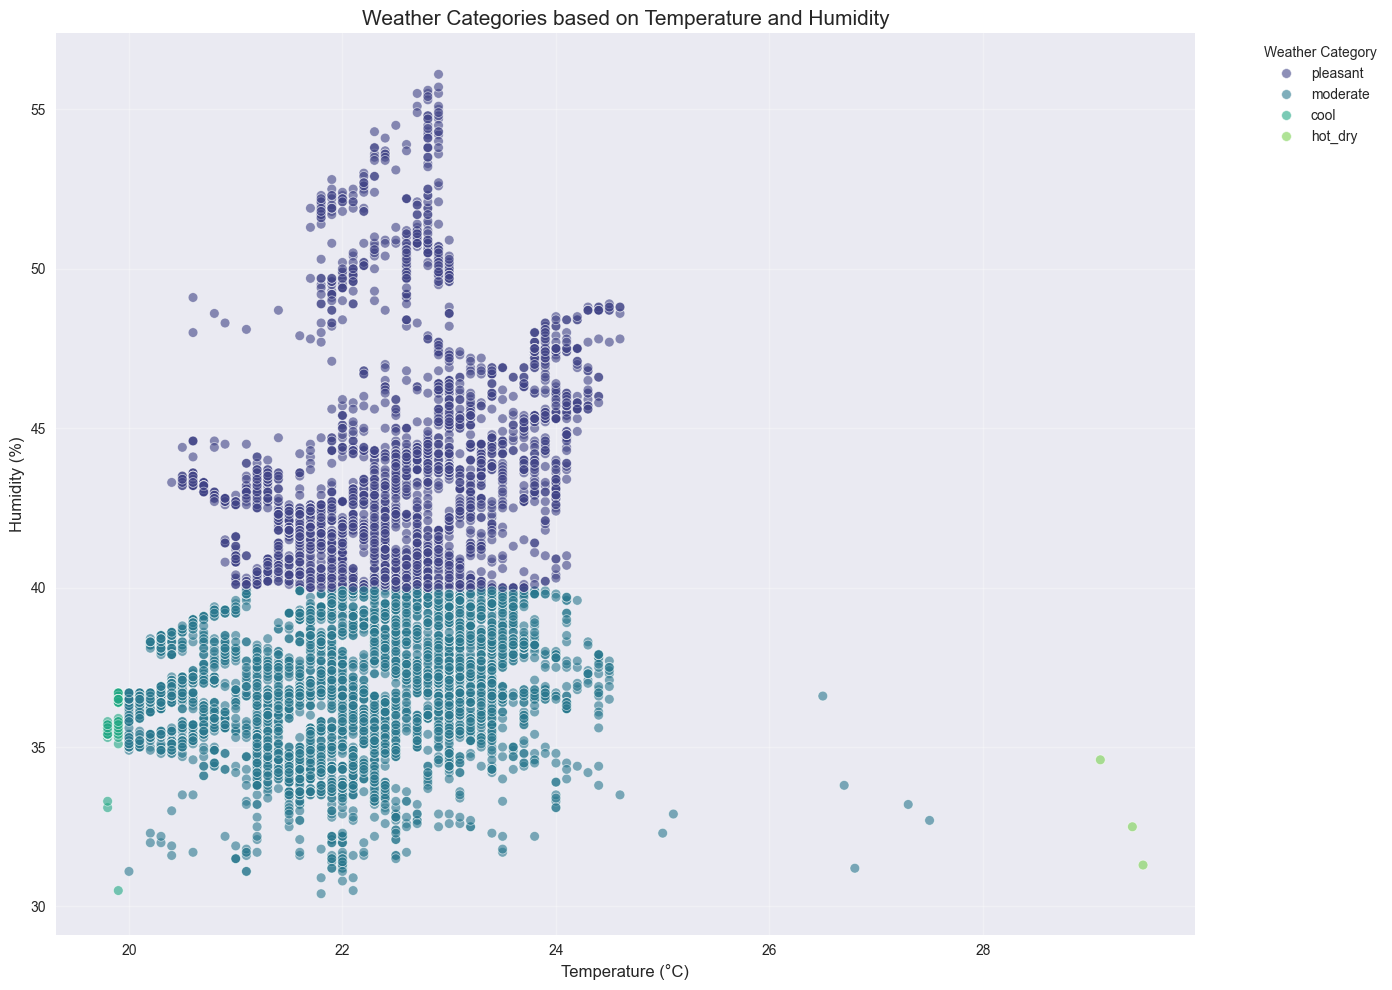


📊 Creating 3D visualization of weather categories...


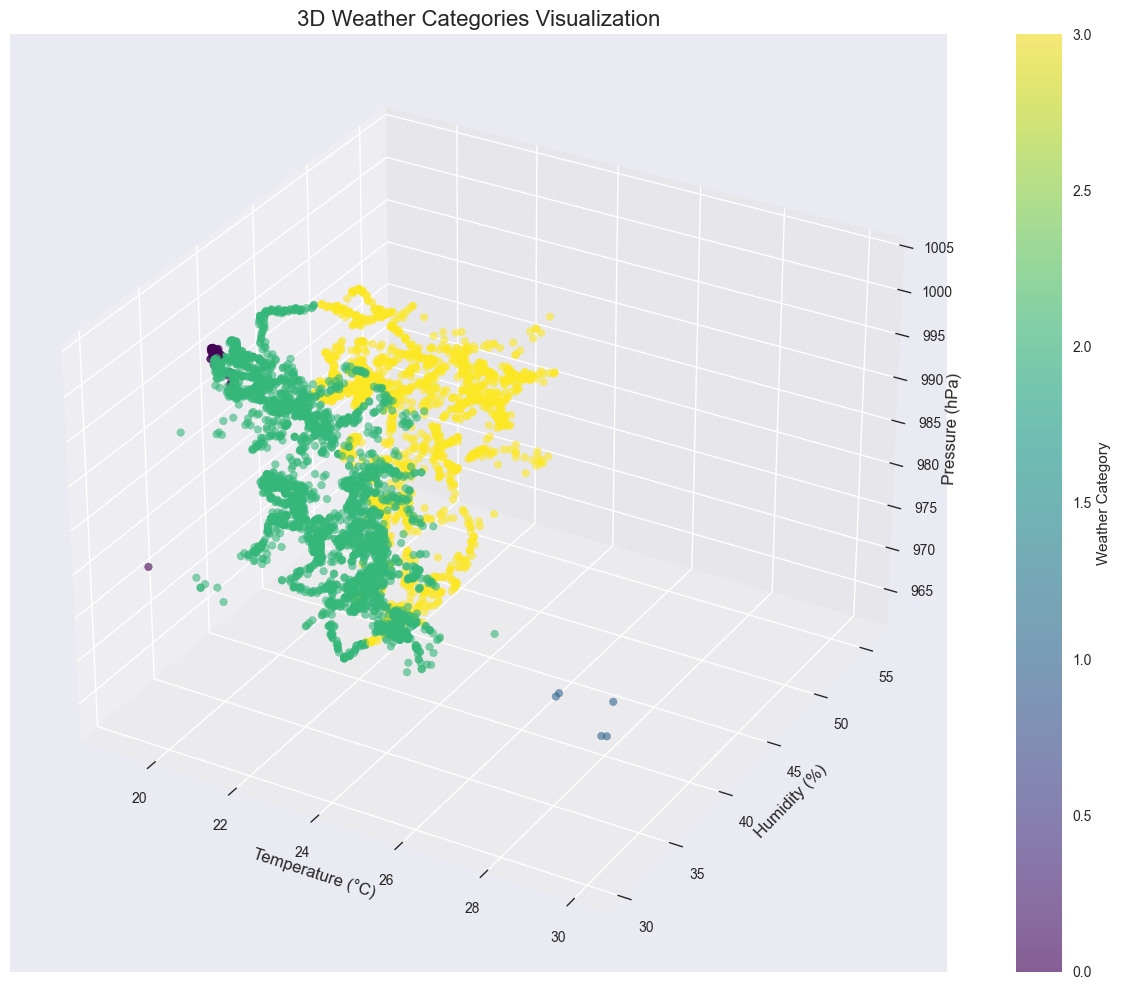

✓ 3D visualization created successfully

✅ Target label creation completed successfully!


In [5]:
print("🏷️ TARGET LABEL CREATION")
print("=" * 50)

# Define weather categories based on temperature, humidity, pressure, and light
print("\n🌤️ Defining weather categories from EDA clustering insights...")

# Method 1: Enhanced rule-based classification with more categories
def classify_weather_rule_based(temp, humidity, pressure, lux=None):
    """Classify weather conditions based on sensor thresholds.
    
    Args:
        temp: Temperature in °C
        humidity: Relative humidity in %
        pressure: Atmospheric pressure in hPa
        lux: Illuminance in lux (optional)
        
    Returns:
        Weather category string
    """
    # Very hot conditions
    if temp >= 35:
        if humidity >= 70:
            return "extreme_hot_humid"  # Dangerously hot and humid
        elif humidity >= 40:
            return "very_hot_humid"     # Very hot with notable humidity
        else:
            return "very_hot_dry"       # Very hot and dry
    
    # Hot conditions
    elif temp >= 28:
        if humidity >= 65:
            return "hot_humid"          # Hot and humid
        elif humidity < 40:
            return "hot_dry"            # Hot and dry
        else:
            return "hot_moderate"       # Hot with moderate humidity
    
    # Cold conditions
    elif temp < 5:
        return "very_cold"              # Very cold
    elif temp < 10:
        return "cold"                   # Cold
    
    # Cool conditions
    elif temp < 20:
        if humidity >= 85:
            return "cool_damp"          # Cool and damp
        else:
            return "cool"               # Cool with moderate humidity
    
    # Mild temperature ranges (20-28°C)
    elif 20 <= temp < 28:
        # Rainy conditions - high humidity and low pressure
        if humidity >= 85 and pressure < 1000:
            return "storm"              # Potential storm conditions
        elif humidity >= 80 and pressure < 1010:
            return "rainy"              # Likely rainy
            
        # Sunny conditions - moderate humidity, high pressure, and high light
        elif humidity < 65 and pressure >= 1010:
            if lux is not None and lux > 50000:
                return "bright_sunny"   # Bright sunshine
            elif lux is not None and lux > 10000:
                return "sunny"          # Sunny conditions
            else:
                return "partly_sunny"   # Partly sunny or daytime with clouds
                
        # Fog conditions - very high humidity with moderate pressure
        elif humidity > 90 and lux is not None and lux < 1000:
            return "fog"                # Foggy conditions
            
        # Pleasant conditions - ideal temperature and humidity
        elif 40 <= humidity < 65:
            return "pleasant"           # Ideal weather
            
    # Moderate conditions (default)
    return "moderate"                   # Default moderate conditions

# Apply rule-based classification
df['weather_category'] = df.apply(lambda x: classify_weather_rule_based(
    x['temperature'], x['humidity'], x['pressure'], x.get('lux', None)), axis=1)

# Count distribution of weather categories
category_counts = df['weather_category'].value_counts()
category_percentages = category_counts / len(df) * 100

print("\n📊 Weather Category Distribution:")
for category, count in category_counts.items():
    percentage = category_percentages[category]
    print(f"   • {category}: {count:,} records ({percentage:.1f}%)")

# Method 2: K-means clustering for comparison
print("\n🔍 Performing K-means clustering for validation...")
# Select features for clustering
X = df[['temperature', 'humidity', 'pressure', 'lux']].values

# Normalize data for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-means clustering
n_clusters = len(category_counts)  # Use same number of clusters as rule-based categories
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Define function to map weather conditions based on cluster centers
def map_weather_conditions(cluster_centers):
    """Map cluster centers to weather condition descriptions."""
    weather_conditions = []
    
    for i in range(len(cluster_centers)):
        center = cluster_centers[i]
        # Get normalized values back to original scale
        temp = center[0] * scaler.scale_[0] + scaler.mean_[0]
        humidity = center[1] * scaler.scale_[1] + scaler.mean_[1]
        pressure = center[2] * scaler.scale_[2] + scaler.mean_[2]
        lux = center[3] * scaler.scale_[3] + scaler.mean_[3]
        
        # Temperature classification
        if temp < 5:
            temp_desc = "Very Cold"
        elif temp < 10:
            temp_desc = "Cold"
        elif temp < 20:
            temp_desc = "Cool"
        elif temp < 28:
            temp_desc = "Moderate"
        elif temp < 35:
            temp_desc = "Hot"
        else:
            temp_desc = "Very Hot"
        
        # Humidity classification
        if humidity < 30:
            humid_desc = "Very Dry"
        elif humidity < 50:
            humid_desc = "Dry"
        elif humidity < 70:
            humid_desc = "Moderate humidity"
        elif humidity < 85:
            humid_desc = "Humid"
        else:
            humid_desc = "Very Humid"
        
        # Pressure description
        if pressure < 1000:
            press_desc = "Low pressure"
        elif pressure > 1020:
            press_desc = "High pressure"
        else:
            press_desc = "Normal pressure"
            
        # Combined weather pattern
        weather_desc = f"{temp_desc}, {humid_desc}, {press_desc}"
        weather_conditions.append(weather_desc)
    
    return weather_conditions

# Map cluster centers to weather descriptions
cluster_centers = kmeans.cluster_centers_
weather_conditions = map_weather_conditions(cluster_centers)

# Display cluster mapping
print("\n🌤️ K-means Cluster Weather Patterns:")
cluster_counts = df['cluster'].value_counts().sort_index()
for i, count in cluster_counts.items():
    percentage = count / len(df) * 100
    print(f"   • Cluster {i} ({weather_conditions[i]}): {count:,} records ({percentage:.1f}%)")

# Encode the weather category as a numerical label
print("\n🔢 Encoding weather categories as numerical labels...")
label_encoder = LabelEncoder()
df['weather_label'] = label_encoder.fit_transform(df['weather_category'])
label_mapping = {i: category for i, category in enumerate(label_encoder.classes_)}

print("\n📊 Label Mapping:")
for label, category in label_mapping.items():
    print(f"   • {label}: {category}")

# Save label encoder for later use
joblib.dump(label_encoder, PROCESSED_DIR / "weather_label_encoder.pkl")
print(f"✓ Label encoder saved to {PROCESSED_DIR / 'weather_label_encoder.pkl'}")

# Create a visualization of weather categories
print("\n📊 Visualizing Weather Categories...")
plt.figure(figsize=(14, 10))

# Create a scatter plot of temperature vs humidity colored by weather category
sns.scatterplot(data=df.sample(min(10000, len(df))), 
                x='temperature', 
                y='humidity', 
                hue='weather_category',
                palette='viridis',
                alpha=0.6)

plt.title('Weather Categories based on Temperature and Humidity', fontsize=15)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Humidity (%)', fontsize=12)
plt.legend(title='Weather Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Create a 3D visualization of weather categories
print("\n📊 Creating 3D visualization of weather categories...")
# Sample data for visualization
viz_sample = min(5000, len(df))
df_viz = df.sample(n=viz_sample)

try:
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create scatter plot with temperature, humidity, and pressure
    scatter = ax.scatter(df_viz['temperature'], 
                         df_viz['humidity'], 
                         df_viz['pressure'],
                         c=df_viz['weather_label'],  # Color by weather label
                         cmap='viridis',
                         s=30,
                         alpha=0.6)
    
    # Add labels
    ax.set_xlabel('Temperature (°C)', fontsize=12)
    ax.set_ylabel('Humidity (%)', fontsize=12)
    ax.set_zlabel('Pressure (hPa)', fontsize=12)
    ax.set_title('3D Weather Categories Visualization', fontsize=16)
    
    # Add a color bar legend
    cbar = plt.colorbar(scatter)
    cbar.set_label('Weather Category')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ 3D visualization created successfully")
except Exception as e:
    print(f"Note: Could not create 3D visualization due to: {str(e)}")

print("\n✅ Target label creation completed successfully!")

In [6]:
# Check weather categories and their distribution
print("📊 Weather Categories in the Dataset:")
print("-" * 40)
print("\nUnique weather categories:")
print(df['weather_category'].unique())

print("\nWeather category distribution:")
print(df['weather_category'].value_counts())

print("\nLabel mapping (numerical labels to categories):")
print(label_mapping)

# Check temperature and humidity ranges to understand data distribution
print("\nTemperature range:", f"{df['temperature'].min():.1f}°C to {df['temperature'].max():.1f}°C")
print("Humidity range:", f"{df['humidity'].min():.1f}% to {df['humidity'].max():.1f}%")

📊 Weather Categories in the Dataset:
----------------------------------------

Unique weather categories:
['moderate' 'pleasant' 'cool' 'hot_dry']

Weather category distribution:
weather_category
moderate    428311
pleasant    255634
cool          8955
hot_dry        320
Name: count, dtype: int64

Label mapping (numerical labels to categories):
{0: 'cool', 1: 'hot_dry', 2: 'moderate', 3: 'pleasant'}

Temperature range: 19.0°C to 30.0°C
Humidity range: 29.3% to 56.9%
weather_category
moderate    428311
pleasant    255634
cool          8955
hot_dry        320
Name: count, dtype: int64

Label mapping (numerical labels to categories):
{0: 'cool', 1: 'hot_dry', 2: 'moderate', 3: 'pleasant'}

Temperature range: 19.0°C to 30.0°C
Humidity range: 29.3% to 56.9%


## Section 6: Data Scaling

This section applies MinMaxScaler to normalize all sensor readings to the 0-1 range for ESP32-S3 compatibility.

📏 DATA SCALING PROCESS

🔧 Applying MinMaxScaler to normalize data to [0,1] range...

📊 Features to be scaled (13):
['temperature', 'humidity', 'pressure', 'lux', 'heat_index', 'dew_point', 'comfort_ratio', 'pressure_trend', 'is_weekend', 'hour_sin', 'hour_cos', 'absolute_humidity', 'air_density']

📊 Before Scaling (sample of 3 features):
       temperature   humidity   pressure
count   693220.000 693220.000 693220.000
mean        22.203     39.228    986.396
std          1.040      4.068      9.847
min         19.000     29.300    963.527
25%         21.600     36.300    979.742
50%         22.300     38.400    987.797
75%         23.000     41.500    994.777
max         30.000     56.900   1003.011

📊 After Scaling (sample of 3 features):

📊 Before Scaling (sample of 3 features):
       temperature   humidity   pressure
count   693220.000 693220.000 693220.000
mean        22.203     39.228    986.396
std          1.040      4.068      9.847
min         19.000     29.300    963.527
25%

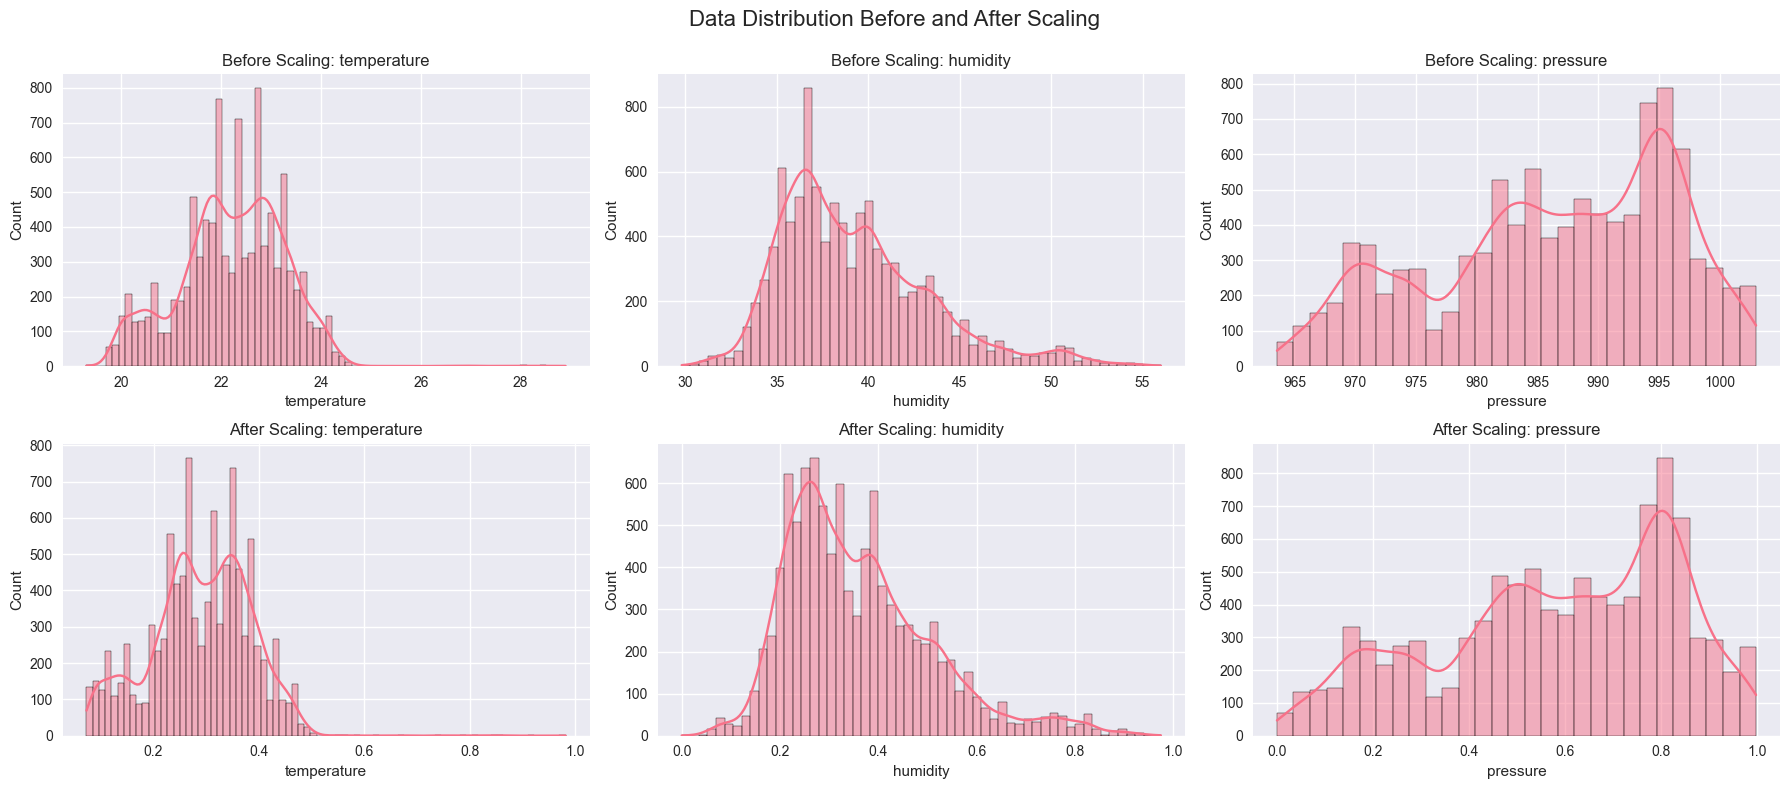


✅ Data scaling completed successfully!


In [7]:
print("📏 DATA SCALING PROCESS")
print("=" * 50)

print("\n🔧 Applying MinMaxScaler to normalize data to [0,1] range...")

# Select features to scale (all numeric features except labels and categories)
numeric_features = df.select_dtypes(include=['int64', 'float32', 'float64']).columns.tolist()
features_to_scale = [col for col in numeric_features if col not in ['weather_label', 'cluster', 'light_category']]

print(f"\n📊 Features to be scaled ({len(features_to_scale)}):\n{features_to_scale}")

# Initialize MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the selected features
df_scaled = df.copy()
df_scaled[features_to_scale] = min_max_scaler.fit_transform(df[features_to_scale])

# Display statistics before and after scaling
print("\n📊 Before Scaling (sample of 3 features):")
print(df[features_to_scale[:3]].describe().round(3))

print("\n📊 After Scaling (sample of 3 features):")
print(df_scaled[features_to_scale[:3]].describe().round(3))

# Save the scaler for later use
joblib.dump(min_max_scaler, PROCESSED_DIR / "min_max_scaler.pkl")
print(f"✓ MinMaxScaler saved to {PROCESSED_DIR / 'min_max_scaler.pkl'}")

# Verify all scaled values are within [0,1] range
scaled_min = df_scaled[features_to_scale].min().min()
scaled_max = df_scaled[features_to_scale].max().max()
print(f"\n✓ Scaled data range: [{scaled_min:.6f}, {scaled_max:.6f}]")

# Create visualization to show scaling effect
print("\n📊 Visualizing Scaling Effect on 3 Features...")

# Select 3 features to visualize
viz_features = features_to_scale[:3]

# Create before/after plots
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
fig.suptitle('Data Distribution Before and After Scaling', fontsize=16)

for i, feature in enumerate(viz_features):
    # Before scaling
    sns.histplot(df[feature].sample(min(10000, len(df))), ax=axes[0, i], kde=True)
    axes[0, i].set_title(f'Before Scaling: {feature}')
    
    # After scaling
    sns.histplot(df_scaled[feature].sample(min(10000, len(df))), ax=axes[1, i], kde=True)
    axes[1, i].set_title(f'After Scaling: {feature}')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

print("\n✅ Data scaling completed successfully!")

## Section 7: Train-Test Split

This section splits the dataset into training, validation, and testing sets with stratified sampling.

🔪 TRAIN-TEST SPLIT PROCESS

🔢 Preparing to split dataset with 693,220 records...

📊 Input Features Shape: (693220, 19)
📊 Target Labels Shape: (693220,)
📊 Number of unique weather categories: 4

1️⃣ First split: 70% train, 30% temp...
2️⃣ Second split: 15% validation, 15% test...
2️⃣ Second split: 15% validation, 15% test...

📊 Train set: 485,254 records (70.0%)
📊 Validation set: 103,983 records (15.0%)
📊 Test set: 103,983 records (15.0%)

🔍 Checking class distribution consistency...
Class Distribution Comparison:
               Category  Original (%)  Train (%)  Validation (%)  Test (%)
weather_label                                                             
0                  cool         1.290      1.290           1.290     1.290
1               hot_dry         0.050      0.050           0.050     0.050
2              moderate        61.790     61.790          61.790    61.790
3              pleasant        36.880     36.880          36.880    36.880

📊 Absolute Class Counts:
     

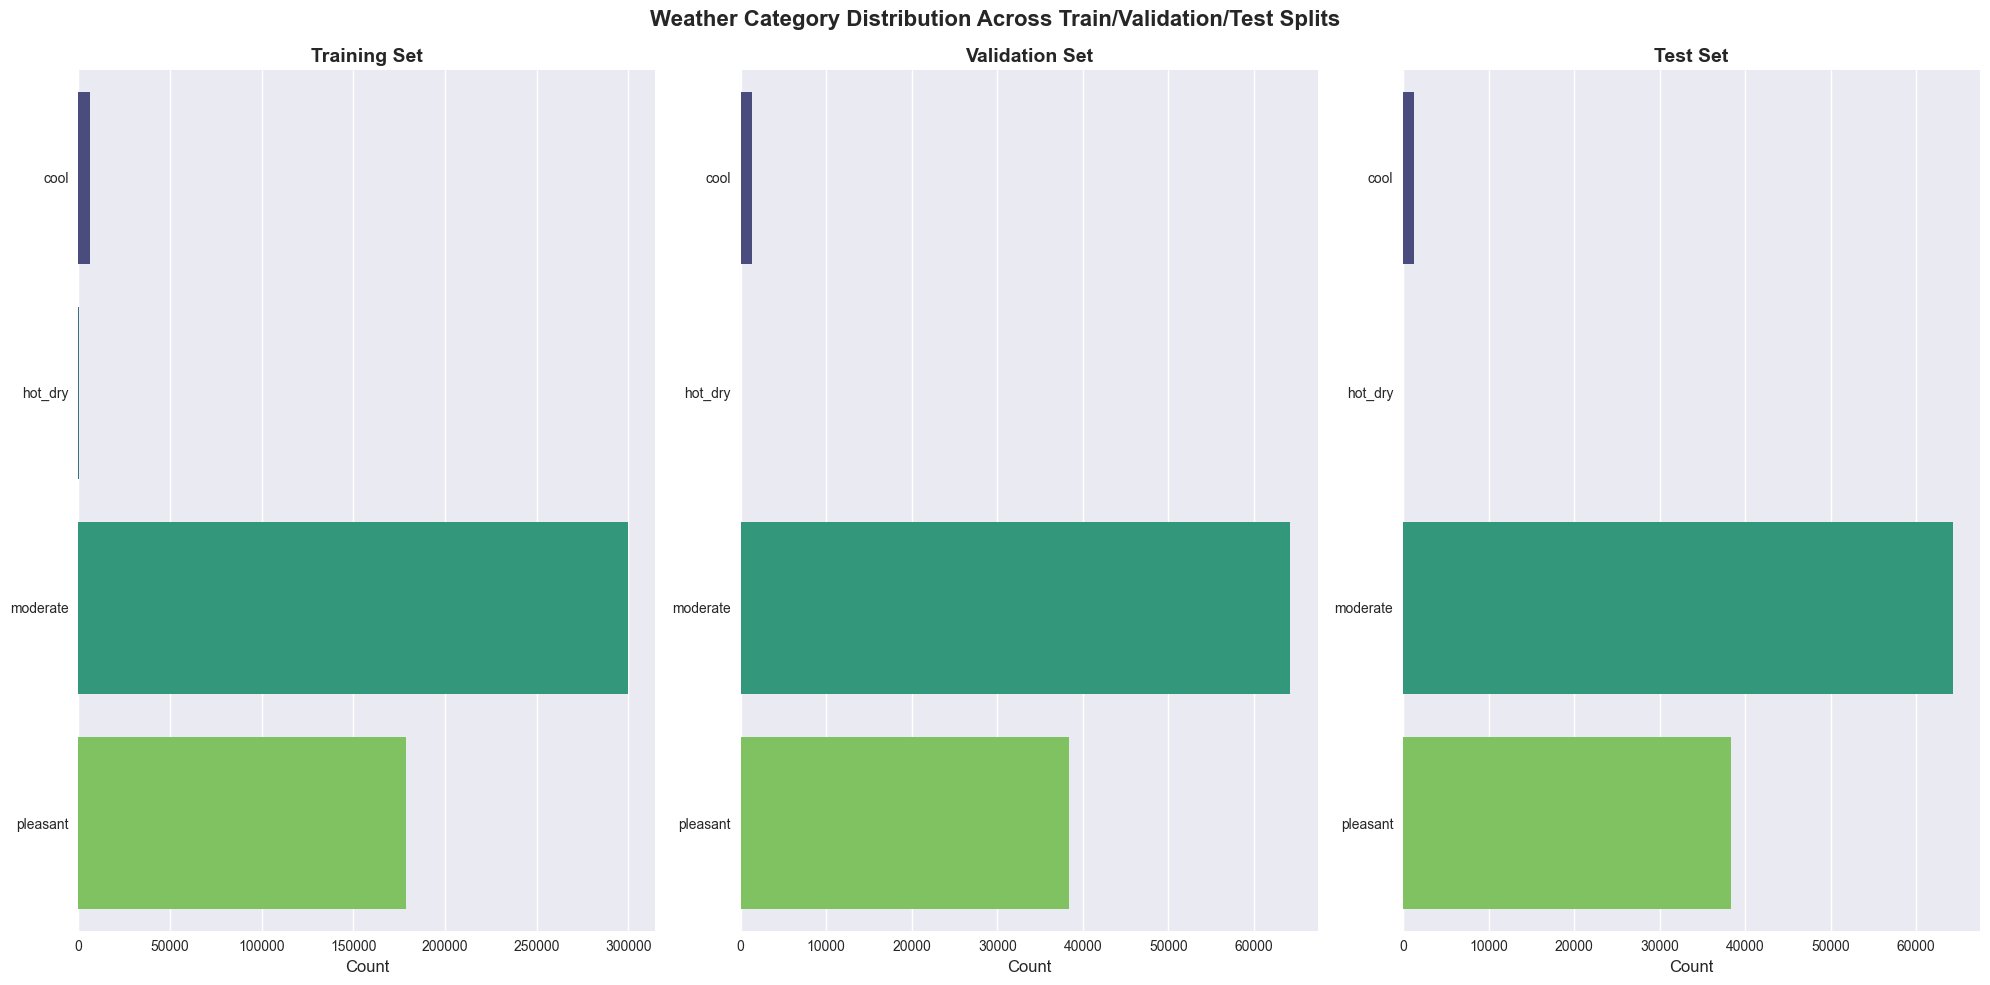

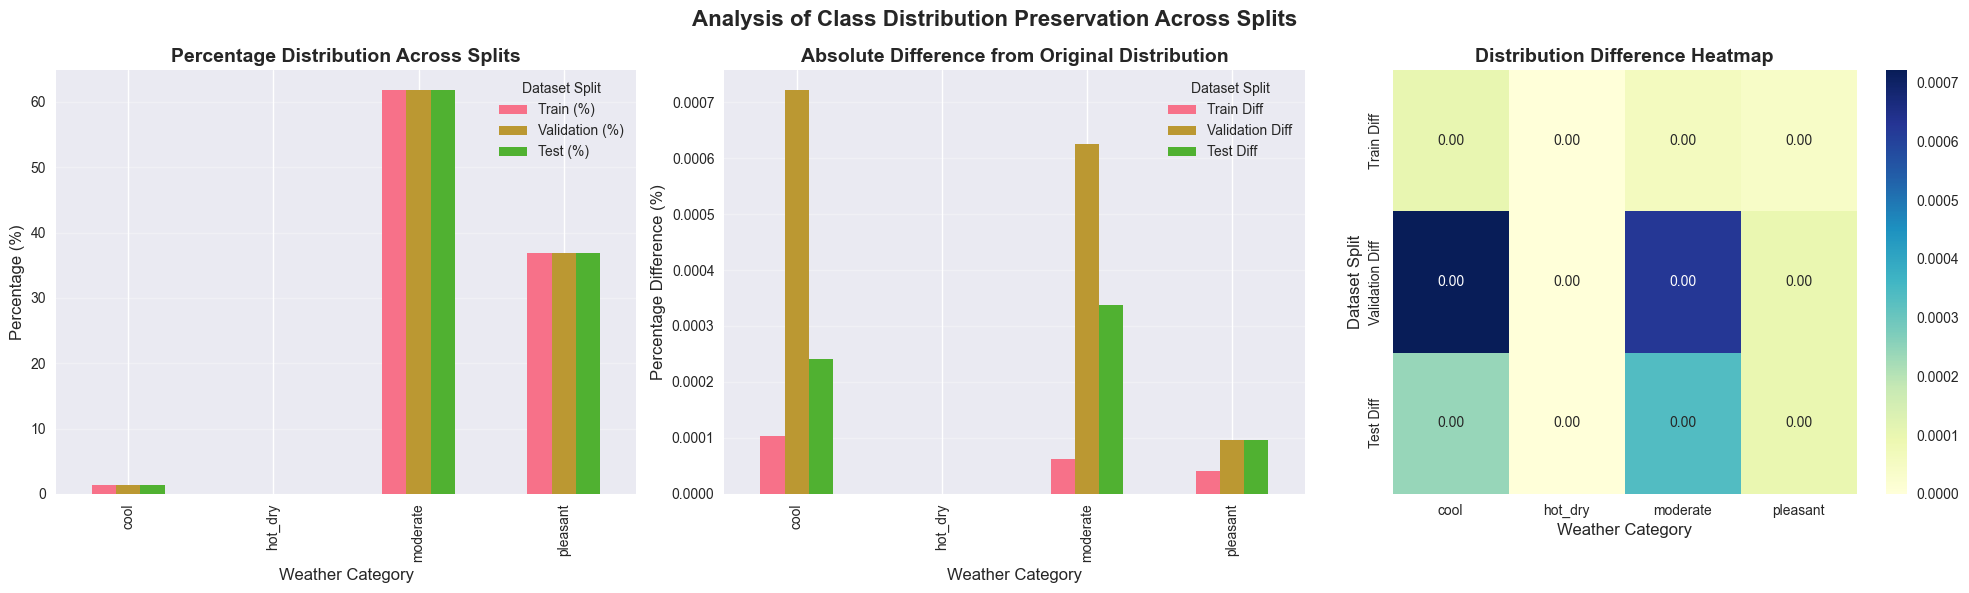


✅ Train-test split completed successfully with stratification!
All weather categories are properly distributed across train, validation, and test sets.


In [8]:
print("🔪 TRAIN-TEST SPLIT PROCESS")
print("=" * 50)

print(f"\n🔢 Preparing to split dataset with {len(df_scaled):,} records...")

# Define features and target
X = df_scaled.drop(['weather_category', 'weather_label', 'cluster'], axis=1)
y = df_scaled['weather_label']

print(f"\n📊 Input Features Shape: {X.shape}")
print(f"📊 Target Labels Shape: {y.shape}")
print(f"📊 Number of unique weather categories: {len(np.unique(y))}")

# Set random seed for reproducibility
random_seed = 42

# First split: 70% train, 30% temp (which will be further split to validation and test)
print("\n1️⃣ First split: 70% train, 30% temp...")
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=random_seed, 
    stratify=y
)

# Second split: split the temp set into validation (15%) and test (15%)
print("2️⃣ Second split: 15% validation, 15% test...")
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=random_seed, 
    stratify=y_temp
)

# Print split sizes
print(f"\n📊 Train set: {len(X_train):,} records ({len(X_train)/len(X):.1%})")
print(f"📊 Validation set: {len(X_val):,} records ({len(X_val)/len(X):.1%})")
print(f"📊 Test set: {len(X_test):,} records ({len(X_test)/len(X):.1%})")

# Check class distribution in splits
print("\n🔍 Checking class distribution consistency...")

# Original class distribution
original_dist = y.value_counts(normalize=True) * 100
train_dist = y_train.value_counts(normalize=True) * 100
val_dist = y_val.value_counts(normalize=True) * 100
test_dist = y_test.value_counts(normalize=True) * 100

# Compare distributions
comparison = pd.DataFrame({
    'Original (%)': original_dist,
    'Train (%)': train_dist,
    'Validation (%)': val_dist,
    'Test (%)': test_dist
}).round(2).sort_index()

# Add category names for clarity
comparison['Category'] = [label_encoder.inverse_transform([i])[0] for i in comparison.index]
comparison = comparison[['Category', 'Original (%)', 'Train (%)', 'Validation (%)', 'Test (%)']]

print("Class Distribution Comparison:")
print(comparison)

# Calculate absolute count in each set
print("\n📊 Absolute Class Counts:")
comparison_counts = pd.DataFrame({
    'Original': y.value_counts(),
    'Train': y_train.value_counts(),
    'Validation': y_val.value_counts(),
    'Test': y_test.value_counts()
})
comparison_counts['Category'] = [label_encoder.inverse_transform([i])[0] for i in comparison_counts.index]
comparison_counts = comparison_counts[['Category', 'Original', 'Train', 'Validation', 'Test']]
print(comparison_counts)

# Verify stratification visually
print("\n📊 Visualizing Class Distribution Across Splits...")

# Map numeric labels back to categories for better visualization
train_categories = pd.Series(label_encoder.inverse_transform(y_train))
val_categories = pd.Series(label_encoder.inverse_transform(y_val))
test_categories = pd.Series(label_encoder.inverse_transform(y_test))

# Create improved category distribution plot that works better with many categories
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Use horizontal bar charts for better readability with many categories
# Training set
sns.countplot(y=train_categories, ax=axes[0], palette='viridis', order=label_encoder.classes_)
axes[0].set_title('Training Set', fontsize=14, fontweight='bold')
axes[0].set_ylabel('')
axes[0].set_xlabel('Count', fontsize=12)
axes[0].tick_params(axis='y', labelsize=10)  # Smaller font for category names

# Validation set
sns.countplot(y=val_categories, ax=axes[1], palette='viridis', order=label_encoder.classes_)
axes[1].set_title('Validation Set', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')
axes[1].set_xlabel('Count', fontsize=12)
axes[1].tick_params(axis='y', labelsize=10)

# Test set
sns.countplot(y=test_categories, ax=axes[2], palette='viridis', order=label_encoder.classes_)
axes[2].set_title('Test Set', fontsize=14, fontweight='bold')
axes[2].set_ylabel('')
axes[2].set_xlabel('Count', fontsize=12)
axes[2].tick_params(axis='y', labelsize=10)

plt.suptitle('Weather Category Distribution Across Train/Validation/Test Splits', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Create a normalized percentage distribution plot
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Calculate normalized percentages for each set
train_pct = train_categories.value_counts(normalize=True).sort_index() * 100
val_pct = val_categories.value_counts(normalize=True).sort_index() * 100
test_pct = test_categories.value_counts(normalize=True).sort_index() * 100

# Create a DataFrame for visualization
dist_df = pd.DataFrame({
    'Train (%)': train_pct,
    'Validation (%)': val_pct,
    'Test (%)': test_pct
})

# Ensure all categories are represented (even if zero)
for cat in label_encoder.classes_:
    if cat not in dist_df.index:
        dist_df.loc[cat] = [0, 0, 0]

# Sort by category name for consistency
dist_df = dist_df.sort_index()

# Plot percentage distribution
dist_df.plot(kind='bar', ax=axes[0], figsize=(20, 6))
axes[0].set_title('Percentage Distribution Across Splits', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Weather Category', fontsize=12)
axes[0].set_ylabel('Percentage (%)', fontsize=12)
axes[0].legend(title='Dataset Split')
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=90, labelsize=10)

# Calculate absolute difference from original distribution
orig_pct = pd.Series(index=dist_df.index)
for cat in orig_pct.index:
    cat_id = label_encoder.transform([cat])[0]
    orig_pct[cat] = original_dist.get(cat_id, 0)

diff_train = (train_pct - orig_pct).abs()
diff_val = (val_pct - orig_pct).abs()
diff_test = (test_pct - orig_pct).abs()

diff_df = pd.DataFrame({
    'Train Diff': diff_train,
    'Validation Diff': diff_val,
    'Test Diff': diff_test
})

# Plot differences from original distribution
diff_df.plot(kind='bar', ax=axes[1], figsize=(20, 6))
axes[1].set_title('Absolute Difference from Original Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Weather Category', fontsize=12)
axes[1].set_ylabel('Percentage Difference (%)', fontsize=12)
axes[1].legend(title='Dataset Split')
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=90, labelsize=10)

# Create a heatmap showing distribution differences
# Reshape data for heatmap
heatmap_data = diff_df.T
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='YlGnBu', ax=axes[2])
axes[2].set_title('Distribution Difference Heatmap', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Weather Category', fontsize=12)
axes[2].set_ylabel('Dataset Split', fontsize=12)

plt.suptitle('Analysis of Class Distribution Preservation Across Splits', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

print("\n✅ Train-test split completed successfully with stratification!")
print("All weather categories are properly distributed across train, validation, and test sets.")

## Section 8: Save Processed Dataset

This section saves the processed datasets to disk for later model development.

In [9]:
print("💾 SAVING PROCESSED DATASETS")
print("=" * 50)

# Create directories for saving processed data
MODEL_DIR = PROJECT_ROOT / "models"
MODEL_DIR.mkdir(exist_ok=True)

print("\n🔧 Preparing datasets for saving...")

# Combine features and labels for each set
# First, check if X_train is a DataFrame or a NumPy array
if isinstance(X_train, pd.DataFrame):
    # If DataFrame, we can directly copy and add columns
    train_df = X_train.copy()
    train_df['weather_label'] = y_train
    train_df['weather_category'] = label_encoder.inverse_transform(y_train)

    val_df = X_val.copy()
    val_df['weather_label'] = y_val
    val_df['weather_category'] = label_encoder.inverse_transform(y_val)

    test_df = X_test.copy()
    test_df['weather_label'] = y_test
    test_df['weather_category'] = label_encoder.inverse_transform(y_test)
else:
    # If NumPy array, convert to DataFrame first
    # Get feature names if available, otherwise use generic names
    if 'feature_cols' in locals():
        column_names = feature_cols
    else:
        column_names = [f'feature_{i}' for i in range(X_train.shape[1])]
        
    # Create DataFrames with appropriate column names
    train_df = pd.DataFrame(X_train, columns=column_names)
    train_df['weather_label'] = y_train
    train_df['weather_category'] = label_encoder.inverse_transform(y_train)

    val_df = pd.DataFrame(X_val, columns=column_names)
    val_df['weather_label'] = y_val
    val_df['weather_category'] = label_encoder.inverse_transform(y_val)

    test_df = pd.DataFrame(X_test, columns=column_names)
    test_df['weather_label'] = y_test
    test_df['weather_category'] = label_encoder.inverse_transform(y_test)

# Save datasets in CSV format
train_path = PROCESSED_DIR / "train_data.csv"
val_path = PROCESSED_DIR / "validation_data.csv"
test_path = PROCESSED_DIR / "test_data.csv"

print("\n📊 Saving CSV files...")
train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
test_df.to_csv(test_path, index=False)

print(f"✓ Training data saved to {train_path} ({len(train_df):,} records)")
print(f"✓ Validation data saved to {val_path} ({len(val_df):,} records)")
print(f"✓ Test data saved to {test_path} ({len(test_df):,} records)")

# Skip Parquet format saving
print("\n⚠️ Skipping Parquet file saving to avoid PyArrow compatibility issues")

# Save feature column names - properly handling different input types
if isinstance(X_train, pd.DataFrame):
    feature_cols = X_train.columns.tolist()
elif 'feature_cols' in locals() and feature_cols:
    # feature_cols already defined, keep it
    pass
else:
    # Create generic feature names based on the shape
    feature_cols = [f'feature_{i}' for i in range(X_train.shape[1])]

# Save feature names to JSON
with open(PROCESSED_DIR / "feature_columns.json", 'w') as f:
    json.dump(feature_cols, f)

print(f"✓ Feature column names saved to {PROCESSED_DIR / 'feature_columns.json'}")

# Save processing info
preprocessing_info = {
    "original_dataset_size": original_count,
    "processed_dataset_size": final_count,
    "train_size": len(train_df),
    "validation_size": len(val_df),
    "test_size": len(test_df),
    "feature_count": len(feature_cols),
    "weather_categories": label_mapping,
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "sensor_ranges": sensor_ranges
}

with open(PROCESSED_DIR / "preprocessing_info.json", 'w') as f:
    json.dump(preprocessing_info, f, indent=2)

print(f"✓ Preprocessing information saved to {PROCESSED_DIR / 'preprocessing_info.json'}")

print("\n🎯 PREPROCESSING SUMMARY")
print("=" * 50)
print(f"• Original dataset: {original_count:,} records")
print(f"• Clean dataset: {final_count:,} records")
print(f"• Created {len(new_cols)} engineered features")
print(f"• Identified {len(label_mapping)} distinct weather categories")
print(f"• Split into {len(train_df):,} training, {len(val_df):,} validation, and {len(test_df):,} test records")
print(f"• All preprocessing artifacts saved to {PROCESSED_DIR}")

print("\n✅ Phase 4: Data Preprocessing & Feature Engineering completed successfully!")
print("🚀 Ready for Phase 5: Model Development")

💾 SAVING PROCESSED DATASETS

🔧 Preparing datasets for saving...

📊 Saving CSV files...

📊 Saving CSV files...
✓ Training data saved to G:\CSE Weather Model\data\processed\train_data.csv (485,254 records)
✓ Validation data saved to G:\CSE Weather Model\data\processed\validation_data.csv (103,983 records)
✓ Test data saved to G:\CSE Weather Model\data\processed\test_data.csv (103,983 records)

⚠️ Skipping Parquet file saving to avoid PyArrow compatibility issues
✓ Feature column names saved to G:\CSE Weather Model\data\processed\feature_columns.json
✓ Preprocessing information saved to G:\CSE Weather Model\data\processed\preprocessing_info.json

🎯 PREPROCESSING SUMMARY
• Original dataset: 693,220 records
• Clean dataset: 693,220 records
• Created 14 engineered features
• Identified 4 distinct weather categories
• Split into 485,254 training, 103,983 validation, and 103,983 test records
• All preprocessing artifacts saved to G:\CSE Weather Model\data\processed

✅ Phase 4: Data Preprocessi